## 1. Data Viewing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, normaltest, boxcox
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from typing import Dict, List
from sklearn.base import BaseEstimator

/tmp/ipykernel_20585/3265854225.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('case_study_junior_ds.csv')

In [3]:
df.head()

,keyword_id,keyword_rank,date,searches,search_engine
0,338145,25218,2022-07-08,53000,0
1,366846,906743,2022-07-08,0,0
2,8590017696,136761,2022-07-08,7000,0
3,8590268435,60380,2022-07-08,20033,0
4,17179954797,239930,2022-07-08,2000,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469308 entries, 0 to 469307
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   keyword_id     469308 non-null  int64 
 1   keyword_rank   469308 non-null  int64 
 2   date           469308 non-null  object
 3   searches       469308 non-null  int64 
 4   search_engine  469308 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 17.9+ MB


CSV contains 469,308 entries and 5 columns. All columns have the same number of non-null entries, which means there are no missing values in dataset. The data types for keyword_id, keyword_rank, searches, and search_engine are integers (int64), and date is an object.

In [5]:
df.describe()

,keyword_id,keyword_rank,searches,search_engine
count,4.693080e+05,4.693080e+05,4.693080e+05,469308.000000
mean,1.955014e+12,7.439009e+05,8.550373e+03,6.818188
std,1.290018e+12,1.388063e+06,8.279563e+04,5.185202
min,5.850000e+03,3.000000e+00,0.000000e+00,0.000000
25%,7.988642e+11,7.421850e+04,0.000000e+00,3.000000
50%,1.838246e+12,2.360955e+05,0.000000e+00,5.000000
75%,3.049427e+12,7.821010e+05,3.000000e+03,10.000000
max,4.389457e+12,1.391182e+07,1.863716e+07,25.000000


The IDs have a wide range, from about 5,850 to 4.389457e+12.
keyword_rank ranks vary from 3 to about 13.9 million. The mean rank is significantly higher than the median, suggesting a right-skewed distribution. 
The majority of keywords have ranks lower than the mean, with a long tail of keywords having very high ranks.
    
searches:
Search volumes range from 0 to over 18.6 million, with a significant standard deviation, indicating high variability in search volumes.
The 25% and 50% quantiles are both 0, showing that at least half of the keywords have no searches.
The mean is much higher than the median, indicating a few keywords with extremely high search volumes that skew the distribution.
    
search_engine:
The search engine codes range from 0 to 25, likely representing different search engines or platforms.
The mean and median values suggest that the distribution of searches across different search engines might be relatively even, but with a spread indicating that some engines are used more than others.

In [6]:
number_search_engine = len(df['search_engine'].unique())
print(f'Number of search engines equal to {number_search_engine}')

Number of search engines equal to 26


## 2. Exploratory Data Analysis (EDA)

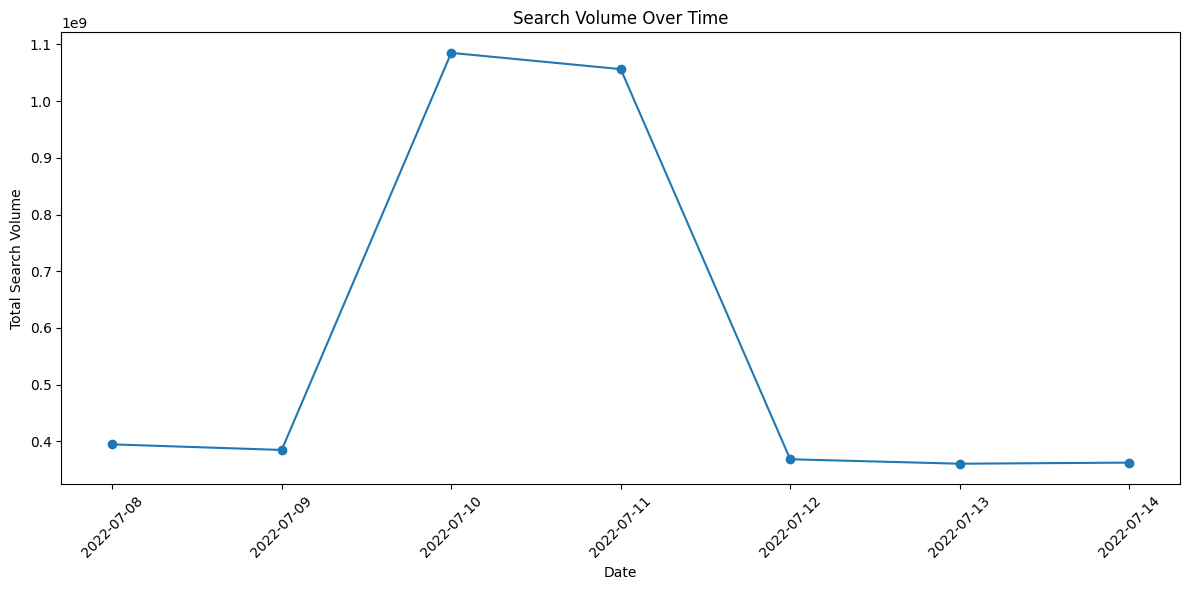

In [7]:
search_volume_over_time = df.groupby('date')['searches'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(search_volume_over_time['date'], search_volume_over_time['searches'], marker='o', linestyle='-')
plt.title('Search Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Total Search Volume')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

Peak Search Volume: A significant surge in search volume is observed around 2022-07-10, suggesting a notable event or seasonal pattern. Further investigation on the dates reveals it to be a Sunday and Monday.

Sharp Drop: Following the peak, there's a rapid decline in search volume on 2022-07-11, almost returning to pre-spike levels. This could mark the conclusion of an event or a temporary surge in interest.

Stable Search Volume: Search volume remains relatively stable before and after the peak, representing the typical baseline level for the dataset.

Possible Outliers: It's crucial to consider whether the peak is an outlier or a recurring pattern. Understanding the context is essential for accurate predictive modeling.modeling.

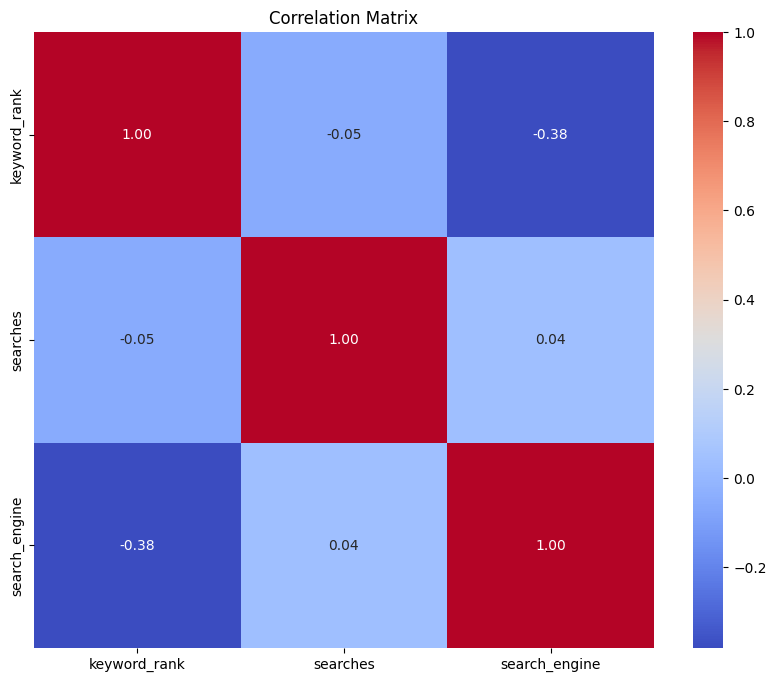

In [8]:
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['keyword_id'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

keyword_rank and searches: There's a very weak negative correlation (-0.05) between keyword_rank and searches, which suggests that as keyword_rank increases, there's a negligible decrease in searches, or vice versa.

keyword_rank and search_engine: There's a moderate negative correlation (-0.38) between keyword_rank and search_engine. This could indicate that different search engines might have differing distributions of keyword ranks, or that lower-ranked keywords are more prevalent in certain search engines.

searches and search_engine: There's a very weak positive correlation (0.04) between searches and search_engine. This suggests almost no linear relationship between the search engine used and the number of searches.

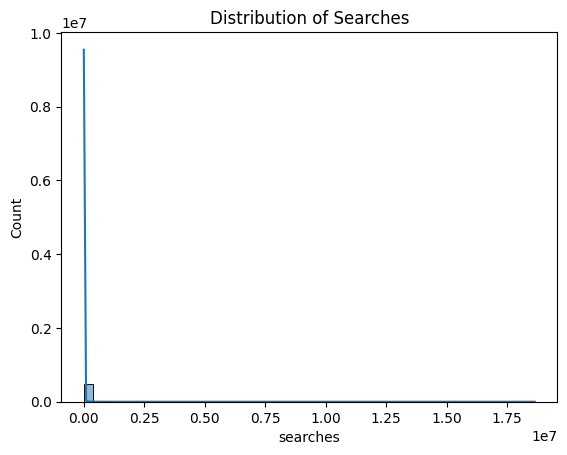

In [9]:
sns.histplot(df['searches'], bins=50, kde=True)
plt.title('Distribution of Searches')
plt.show()

From distribution of Searches we can learn, that histogram shows a highly skewed distribution of searches with a concentration of values at the lower end of the scale. This suggests that a large number of the search terms have relatively few searches.

Presence of Outliers: The long tail extending to the right indicates the presence of outliers with very high search counts compared to the majority of the data.

Scale of the Data: The x-axis is scaled from 0 to around 20 million (2e7), which indicates the range of searches. Most of the data is clustered close to zero, indicating that high search volumes are ral insights.

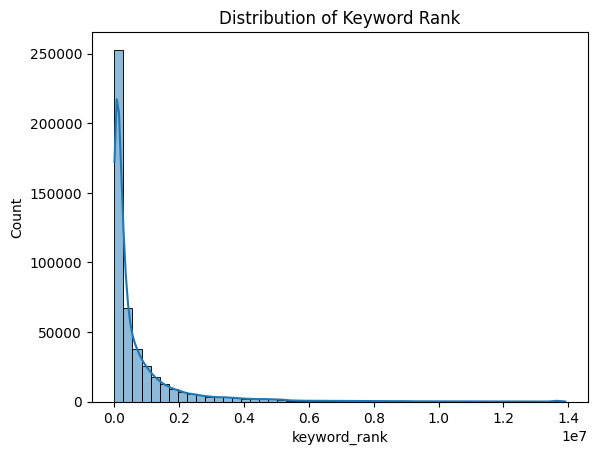

In [10]:
sns.histplot(df['keyword_rank'], bins=50, kde=True)
plt.title('Distribution of Keyword Rank')
plt.show()

The histogram shows the keyword_rank is right-skewed, with most ranks low in the range, extending from 0 to 14 million. This skewness means analytical techniques assuming normality may not fit well without transforming the data, possibly through logarithmic scaling, to normalize the distribution for uses like regression modeling. Considering a logarithmic view or non-linear models could better accommodate the skewness without transforming the data.

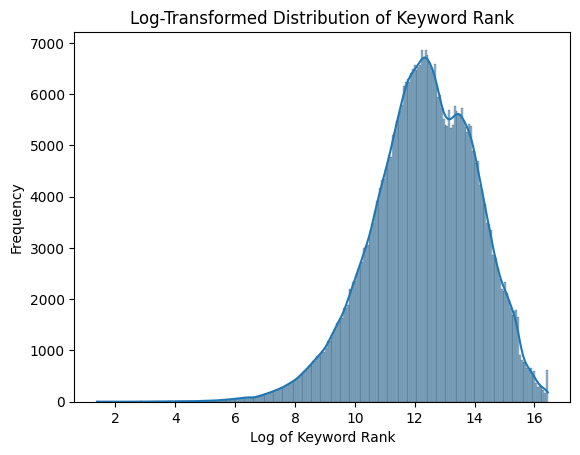

In [11]:
df['log_keyword_rank'] = np.log1p(df['keyword_rank'])

# Visualize the log-transformed keyword rank
sns.histplot(df['log_keyword_rank'], kde=True)
plt.title('Log-Transformed Distribution of Keyword Rank')
plt.xlabel('Log of Keyword Rank')
plt.ylabel('Frequency')
plt.show()

Log transformation has made the `keyword_rank` distribution more bell-shaped, closer to normal, which benefits statistical models requiring normally distributed inputs. It shows a central peak and slight right skewness, but less than before transformation. This makes it more compatible with linear models. Next steps include conducting normality tests to confirm this improvement and using the transformed data in predictive models to assess the transformation's impact compared to non-transformed data.

In [12]:
# Shapiro-Wilk Test
stat, p_value_shapiro = shapiro(df['log_keyword_rank'])
print('Shapiro-Wilk Test p-value:', p_value_shapiro)

# D'Agostino's K-squared Test
stat, p_value_agostino = normaltest(df['log_keyword_rank'])
print("D'Agostino's K-squared Test p-value:", p_value_agostino)

Shapiro-Wilk Test p-value: 1.0172109890142232e-81
D'Agostino's K-squared Test p-value: 0.0


/tmp/ipykernel_20585/3136507951.py:2: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 469308.
  stat, p_value_shapiro = shapiro(df['log_keyword_rank'])


The p-values you've provided for both the Shapiro-Wilk Test and D'Agostino's K-squared Test are essentially zero when considering typical significance levels (e.g., 0.05 or 0.01). This strongly suggests that the log-transformed keyword_rank distribution significantly deviates from a normal distribution.

If log transformation does not yield a normal distribution, other transformations like Box-Cox or Yeo-Johnson (which are generalizations of log transformation) could be tested to see if they result in a distribution that better meets the assumptions of your analysis methods.


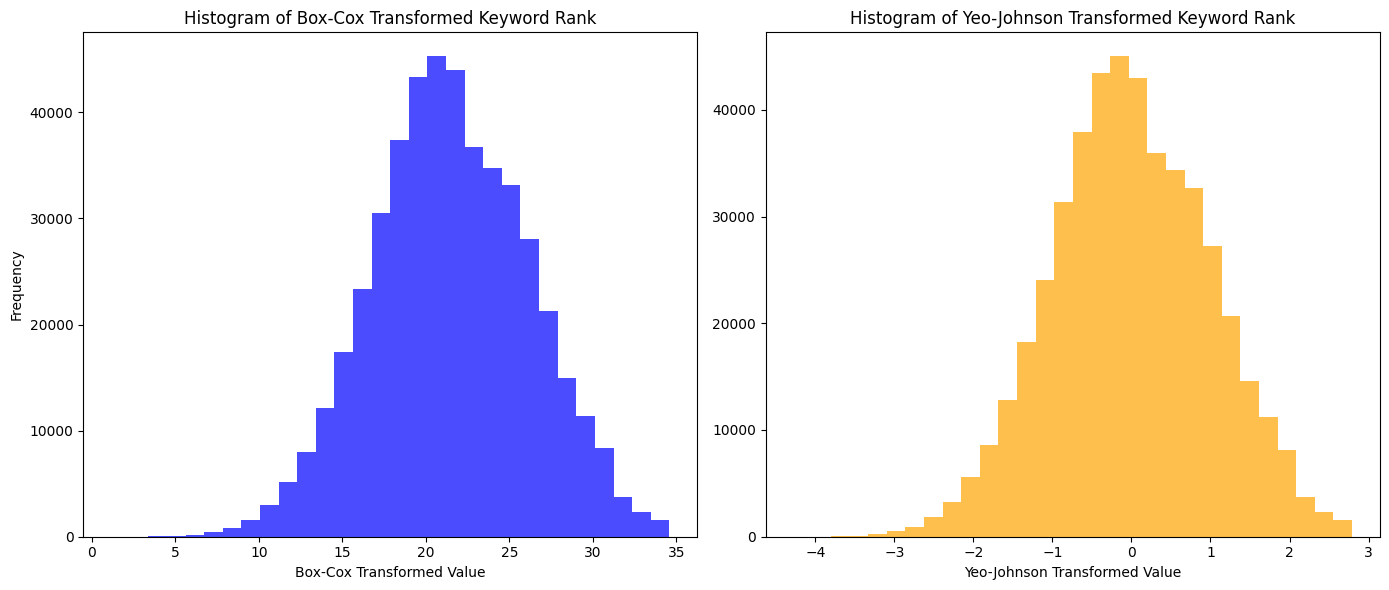

Fitted Lambda for Box-Cox: 0.08138892011954271
Box-Cox - Shapiro-Wilk test statistic=0.9989012145783226, p-value=7.802868369650742e-37
Yeo-Johnson - Shapiro-Wilk test statistic=0.998901001482111, p-value=7.748505903822875e-37


/tmp/ipykernel_20585/930184240.py:24: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 469308.
  stat, p_value = shapiro(df['keyword_rank_boxcox'])
/tmp/ipykernel_20585/930184240.py:27: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 469308.
  stat, p_value = shapiro(df['keyword_rank_yeojohnson'])


In [13]:
df['keyword_rank_boxcox'], fitted_lambda = boxcox(df['keyword_rank'])

pt = PowerTransformer(method='yeo-johnson')
df['keyword_rank_yeojohnson'] = pt.fit_transform(df[['keyword_rank']])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['keyword_rank_boxcox'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Box-Cox Transformed Keyword Rank')
plt.xlabel('Box-Cox Transformed Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['keyword_rank_yeojohnson'], bins=30, color='orange', alpha=0.7)
plt.title('Histogram of Yeo-Johnson Transformed Keyword Rank')
plt.xlabel('Yeo-Johnson Transformed Value')

plt.tight_layout()
plt.show()

print(f'Fitted Lambda for Box-Cox: {fitted_lambda}')

stat, p_value = shapiro(df['keyword_rank_boxcox'])
print(f'Box-Cox - Shapiro-Wilk test statistic={stat}, p-value={p_value}')

stat, p_value = shapiro(df['keyword_rank_yeojohnson'])
print(f'Yeo-Johnson - Shapiro-Wilk test statistic={stat}, p-value={p_value}')

Transformations significantly enhanced the keyword ranks' distribution symmetry. The Box-Cox transformation shows skewness towards higher values, typical for keyword rankings. Yeo-Johnson transformation yields a nearly bell-shaped, more normal-like distribution. Despite visual improvements, Shapiro-Wilk tests reveal neither dataset is perfectly normal (p-value near zero), but test statistics close to 1 suggest near-normal distributions. The slight modification indicated by Box-Cox's lambda improves symmetry. Lets check if this transformations improve modelly normal.

Lets calculate total_searches_per_engine and average_searches_per_engine. To see if this two days affect our reasearch we create dataframes that include and exclude this days and see if this have impact on graph except increases of searches for search engines.

In [14]:
total_searches_per_engine = df.groupby('search_engine')['searches'].sum().reset_index()

total_searches_per_engine.rename(columns={'searches': 'total_searches'}, inplace=True)

total_searches_per_engine

,search_engine,total_searches
0,0,253594309
1,1,327011326
2,2,1077400
3,3,138954856
4,4,150629643
5,5,197381514
6,6,640087433
7,7,246908881
8,8,164388564
9,9,254912160


In [15]:
average_searches_per_engine = df.groupby('search_engine')['searches'].mean().reset_index()

average_searches_per_engine.rename(columns={'searches': 'average_searches'}, inplace=True)

average_searches_per_engine

,search_engine,average_searches
0,0,5427.379540
1,1,9863.404898
2,2,2443.083900
3,3,3343.556293
4,4,1750.286347
5,5,6689.991662
6,6,26082.369626
7,7,9368.578296
8,8,7290.928461
9,9,11038.503443


In [16]:
dates_to_remove = ['2022-07-10', '2022-07-11']
df_filtered = df[~df['date'].isin(dates_to_remove)]

df_filtered

,keyword_id,keyword_rank,date,searches,search_engine,log_keyword_rank,keyword_rank_boxcox,keyword_rank_yeojohnson
0,338145,25218,2022-07-08,53000,0,10.135353,15.747323,-1.224316
1,366846,906743,2022-07-08,0,0,13.717615,25.237211,0.799959
2,8590017696,136761,2022-07-08,7000,0,11.825997,19.882876,-0.342109
3,8590268435,60380,2022-07-08,20033,0,11.008430,17.811925,-0.783879
4,17179954797,239930,2022-07-08,2000,0,12.388107,21.388810,-0.020881
...,...,...,...,...,...,...,...,...
469303,283467963549,1396,2022-07-14,13000,25,7.242082,9.864326,-2.479266
469304,678604970059,5133,2022-07-14,3000,25,8.543640,12.340673,-1.951068
469305,2482491145775,3980,2022-07-14,7000,25,8.289288,11.835982,-2.058731
469306,2791728932601,6522,2022-07-14,1357,25,8.783090,12.825416,-1.847658


In [17]:
average_searches_per_engine_filtered = df_filtered.groupby('search_engine')['searches'].mean().reset_index()
average_searches_per_engine_filtered.rename(columns={'searches': 'average_searches'}, inplace=True)

average_searches_per_engine_filtered

,search_engine,average_searches
0,0,3679.852909
1,1,6364.090684
2,2,1021.222222
3,3,2416.017264
4,4,1292.711751
5,5,4832.473626
6,6,13676.047772
7,7,5636.120339
8,8,5669.861179
9,9,5904.698588


In [18]:
total_searches_per_engine_filtered = df_filtered.groupby('search_engine')['searches'].sum().reset_index()
total_searches_per_engine_filtered.rename(columns={'searches': 'total_searches'}, inplace=True)

total_searches_per_engine_filtered

,search_engine,total_searches
0,0,121935606
1,1,149269747
2,2,312494
3,3,71373982
4,4,78755878
5,5,101051856
6,6,237894851
7,7,105660348
8,8,90712109
9,9,97049626


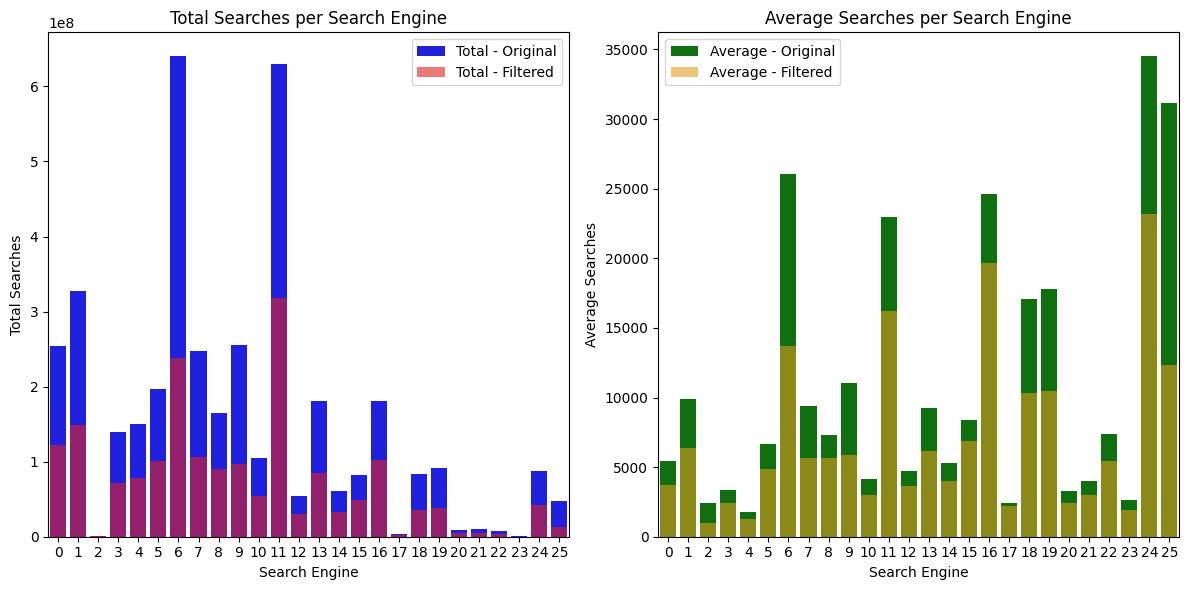

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='search_engine', y='total_searches', data=total_searches_per_engine, color='blue', label='Total - Original')
sns.barplot(x='search_engine', y='total_searches', data=total_searches_per_engine_filtered, color='red', alpha=0.6, label='Total - Filtered')
plt.title('Total Searches per Search Engine')
plt.xlabel('Search Engine')
plt.ylabel('Total Searches')
plt.legend()

plt.subplot(1, 2, 2)
sns.barplot(x='search_engine', y='average_searches', data=average_searches_per_engine, color='green', label='Average - Original')
sns.barplot(x='search_engine', y='average_searches', data=average_searches_per_engine_filtered, color='orange', alpha=0.6, label='Average - Filtered')
plt.title('Average Searches per Search Engine')
plt.xlabel('Search Engine')
plt.ylabel('Average Searches')
plt.legend()

plt.tight_layout()
plt.show()



The graph illustrates that search engine number 6 dominates in terms of overall weekly performance, whereas on average, search engine number 24 outperforms others. Despite fluctuations in search volumes over these two days, the relative popularity of search engines remains largely consistent. Less popular search engines continue to trail behind the more popular ones, with no significant shifts in their relative positions.h volumes.nd vice versa.

## 3. Prediction

Let's define the model parameters for our prediction task. I've opted for two different models: a simple one, which is a linear regression with ridge regularization, and a more advanced option, the RandomForestRegressor. We will use the ridge regression to investigate whether transformations applied to the keyword rank can enhance the predictive performance of the model.

In [20]:
model_params = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'Ridge__alpha': [1, 10, 100]  # Regularization strength
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {}
    },
}

### 3.1 Average / Total / Max approach


In this approach, we develop a predictive model capable of forecasting three key metrics. Firstly, it estimates the average number of searches conducted per week. Secondly, it predicts the total search volume achieved over the course of a week. Lastly, it forecasts the maximum potential search engine capacity.

In [21]:
def train_model(X, y, x_columnes: List, model_params: Dict) -> BaseEstimator:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), [x_columnes[0]]),
            ('cat', OneHotEncoder(), [x_columnes[1]])
        ])

    X_preprocessed = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
    
    results = []
    for model_name, mp in model_params.items():
        pipeline = Pipeline([(model_name, mp['model'])])
        grid_search = GridSearchCV(pipeline, 
                                   mp['params'], 
                                   cv=5, 
                                   scoring=rmse_scorer, 
                                   n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'model': model_name,
            'best_params': grid_search.best_params_,
            'rmse': rmse
        })
    
    print(pd.DataFrame(results))
    return best_model

In [22]:
def predict_searches_per_engine(model: BaseEstimator, x: pd.DataFrame) -> List:
    return model.predict(x)

In [23]:
def get_predict_searches_each_engine(model: BaseEstimator, rank: int, x_columns: List, y_columnes: List, number_engines: int) -> pd.DataFrame:
    predictions = [predict_searches_per_engine(model, pd.DataFrame([(rank, engine)], columns=x_columns)) for engine in range(number_engines)]
    return pd.DataFrame(predictions, columns=y_columns)


In [24]:
def get_aggregated_data(df: pd.DataFrame, columns: List) -> pd.DataFrame:
    return df.groupby(columns).agg(
        total_searches=pd.NamedAgg(column='searches', aggfunc='sum'),
        average_searches=pd.NamedAgg(column='searches', aggfunc='mean'),
        max_searches=pd.NamedAgg(column='searches', aggfunc='max')
    ).reset_index()
    

In [25]:
def get_search_engines_for_rank(rank: int, data:pd.DataFrame, X_columnes: List, y_columnes: List) -> pd.DataFrame:
    X = data[x_columnes]
    y = data[y_columnes]
    model = train_model(X, y, X_columnes, model_params)
    return get_predict_searches_each_engine(model, rank, X_columnes, y_columnes, number_search_engine)

In [26]:
df

,keyword_id,keyword_rank,date,searches,search_engine,log_keyword_rank,keyword_rank_boxcox,keyword_rank_yeojohnson
0,338145,25218,2022-07-08,53000,0,10.135353,15.747323,-1.224316
1,366846,906743,2022-07-08,0,0,13.717615,25.237211,0.799959
2,8590017696,136761,2022-07-08,7000,0,11.825997,19.882876,-0.342109
3,8590268435,60380,2022-07-08,20033,0,11.008430,17.811925,-0.783879
4,17179954797,239930,2022-07-08,2000,0,12.388107,21.388810,-0.020881
...,...,...,...,...,...,...,...,...
469303,283467963549,1396,2022-07-14,13000,25,7.242082,9.864326,-2.479266
469304,678604970059,5133,2022-07-14,3000,25,8.543640,12.340673,-1.951068
469305,2482491145775,3980,2022-07-14,7000,25,8.289288,11.835982,-2.058731
469306,2791728932601,6522,2022-07-14,1357,25,8.783090,12.825416,-1.847658


In [27]:
columns = ['keyword_rank', 'log_keyword_rank', 'keyword_rank_boxcox', 'keyword_rank_yeojohnson','search_engine']
aggregated_data = get_aggregated_data(df, columns)
aggregated_data

,keyword_rank,log_keyword_rank,keyword_rank_boxcox,keyword_rank_yeojohnson,search_engine,total_searches,average_searches,max_searches
0,3,1.386294,1.149226,-4.271646,8,2548918,1274459.0,1334983
1,3,1.386294,1.149226,-4.271646,13,27216147,4536024.5,10424650
2,4,1.609438,1.467528,-4.217833,13,2490750,2490750.0,2490750
3,5,1.791759,1.719606,-4.173135,8,2272664,1136332.0,1269056
4,6,1.945910,1.928994,-4.134822,13,11023751,5511875.5,5527120
...,...,...,...,...,...,...,...,...
460426,13877399,16.445772,34.566537,2.789548,0,0,0.0,0
460427,13878593,16.445858,34.566865,2.789618,0,0,0.0,0
460428,13878669,16.445864,34.566886,2.789623,0,0,0.0,0
460429,13879538,16.445926,34.567124,2.789674,0,0,0.0,0


In [28]:
x_columnes = ['keyword_rank', 'search_engine']
y_columnes = ['total_searches', 'average_searches', 'max_searches']
prediction = get_search_engines_for_rank(1, aggregated_data, x_columnes, y_columnes)
prediction

                   model            best_params          rmse
0                  Ridge  {'Ridge__alpha': 100}  67356.692839
1  RandomForestRegressor                     {}  46146.285696


ValueError: Must pass 2-d input. shape=(26, 1, 3)

In [ ]:
x_columnes = ['log_keyword_rank', 'search_engine']
y_columnes = ['total_searches', 'average_searches', 'max_searches']
prediction = get_search_engines_for_rank(np.log1p(1), aggregated_data, x_columnes, y_columnes)
prediction

In [ ]:
x_columnes = ['keyword_rank_boxcox', 'search_engine']
y_columnes = ['total_searches', 'average_searches', 'max_searches'] 
prediction = get_search_engines_for_rank(0, aggregated_data, x_columnes, y_columnes)
prediction

In [ ]:
x_columnes = ['keyword_rank_yeojohnson', 'search_engine']
y_columnes = ['total_searches', 'average_searches', 'max_searches']
prediction = get_search_engines_for_rank(pt.transform([[1]]), aggregated_data, x_columnes, y_columnes)
prediction

Predicion shows, that log-transformation improve Ridge performance. In case of box-cox and yeo-johnson we also see this, but change is slightly diffrent than logarithmic approach so it is no as beneficial.

### 3.1 Seven days approach

Let's try another approach is to create model which will predict search value for every day. In this case output is seven elements list. For this we need to extract days from date

First create mapping for days as friday we will set as zero (first in our date)

In [ ]:
day_mapping = {
    0: 'Friday',
    1: 'Saturday',
    2: 'Sunday',
    3: 'Monday',
    4: 'Tuesday',
    5: 'Wednesday',
    6: 'Thursday'
}

In [ ]:
df_time = df.copy()
df_time['date'] = pd.to_datetime(df['date'])
reference_date = pd.to_datetime('2022-07-08').dayofweek  # This gets the day of week for 2022-07-08
df_time['day_of_week'] = (df_time['date'].dt.dayofweek - reference_date) % 7
df_time


In [ ]:
pivot_df = df_time.pivot_table(index=['keyword_rank', 'search_engine', 'log_keyword_rank'], 
                          columns='day_of_week', 
                          values='searches', 
                          aggfunc=np.sum, 
                          fill_value=0).reset_index()

pivot_df.rename(columns=day_mapping, inplace=True)

pivot_df

In [ ]:
x_columnes = ['keyword_rank', 'search_engine']
y_columnes = list(day_mapping.values())
prediction = get_search_engines_for_rank(1, pivot_df, x_columnes, y_columnes)
prediction

In [ ]:
x_columnes = ['log_keyword_rank', 'search_engine']
y_columnes = list(day_mapping.values())
prediction = get_search_engines_for_rank(np.log1p(1), pivot_df, x_columnes, y_columnes)
prediction

Skip box-cox transformations and yeo-johnson, as they not improve model significantly

### 3.3 Prediction with removed outliers ('2022-07-10', '2022-07-11')

In [ ]:
columns = ['keyword_rank', 'log_keyword_rank', 'keyword_rank_boxcox', 'keyword_rank_yeojohnson','search_engine']
aggregated_data = get_aggregated_data(df_filtered, columns)

In [ ]:
x_columnes = ['keyword_rank', 'search_engine']
y_columnes = ['total_searches', 'average_searches', 'max_searches']
prediction = get_search_engines_for_rank(1, aggregated_data, x_columnes, y_columnes)
prediction

In [ ]:
x_columnes = ['log_keyword_rank', 'search_engine']
y_columnes = ['total_searches', 'average_searches', 'max_searches']
prediction = get_search_engines_for_rank(np.log1p(1), aggregated_data, x_columnes, y_columnes)
prediction

In [ ]:
pivot_df = pivot_df.drop(columns=['Sunday', 'Monday'])
pivot_df

In [ ]:
y_columnes = list(day_mapping.values())
y_columnes = y_columnes[:2] + y_columnes[4:] 

In [ ]:
x_columnes = ['keyword_rank', 'search_engine']
prediction = get_search_engines_for_rank(1, pivot_df, x_columnes, y_columnes)
prediction

In [ ]:
x_columnes = ['log_keyword_rank', 'search_engine']
prediction = get_search_engines_for_rank(np.log1p(1), pivot_df, x_columnes, y_columnes)
prediction

We observe significant improvements with both Ridge and RandomForest Regression models. This leads us to a pivotal decision: determining the significance of the data from July 10th and 11th for our learning models. If these dates represented unusual spikes in keyword searches that are unlikely to recur soon, then models trained on data from other days might predict values more accurately. However, if these days (Sunday and Monday) are consistently important for keyword searches and this pattern is expected to repeat weekly, we must incorporate this data into our models.

## 4. Conclusion

Based on researches we see two approaches to estimate number of searches for every search_engine with rank 1. We can use used approach of estimate average couning, total number of searches and maximum searches for presentation. Also we can predict searches for every day making it visible how many searches we need for every day. Important here is to discussed if increased in number of searches during 2022-07-10 and 2022-07-11 are ocassionally due to some unexpected events or are repeated situation. In first case we get easier approach for models to predict value and simple linear regression with ridge regularization can provide good estimation (we dont need more advanced models, as we see they no achieve much better results). In second approach we need to used more advanced models. We can used log-transformation on keyword_rank to improve linear models, but futher transformation do not provide significant difference.

Another important things is correlation between each of values. There's a very weak negative correlation (-0.05) between keyword_rank and searches, indicating a minimal decrease in searches as keyword_rank increases, or vice versa. : There's a moderate negative correlation (-0.38) between keyword_rank and search_engine. This implies differing distributions of keyword ranks among different search engine ne: There's a very weak positive correlation (0.04) between searches and search_engine, suggesting almost no linear relationship between the search engine used and the number of searc

Researches also shows that day do not change popularity of search engines. Popular search engines will get more searches then less popular, so in choosing search_engines we should not look on time, more on overall performance.

We can improve prediction in choosing more advanced models like Gradient Boosting Regressor or neural networks - dense layers or RNN.hes.

In [ ]:
# Exemplary models to use with parameters 

In [ ]:
model_params = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],  # Number of trees in the forest
            'max_depth': [10, 20, None],     # Maximum depth of the tree
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required to be at a leaf node
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
            'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
            'max_depth': [3, 4, 5],            # Maximum depth of the individual regression estimators
            'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [1, 10, 100, 1000]  # Regularization strength
        }
    }